# Business Case 4: Cryptocurrencies Forecasting

## Contents:
  
 * [Modeling ADA](#Modeling)
 * [ADA - Entire Dataset](#entiredataset)
    * [Model 1: LSTM](#lstm)
    * [Model 2: XGBOOST Regressor](#xgboost)
 * [ADA - since January 2021](#jan2021)
    * [Model 1: LSTM](#lstm2)
    * [Model 2: XGBOOST Regressor](#xgboost2)
 * [ADA - since January 2022](#jan2022)
    * [Model 1: LSTM](#lstm3)
    * [Model 2: XGBOOST Regressor](#xgboost3)
 * [Predictions for the next two days using the best model](#predictions)

## Imports

In [1]:
#! pip install xgboost
#! pip install fastai==0.7.0
#! pip install --upgrade tensorflow
#! pip install keras
#! pip install pystan
#! pip install ephem
#! pip install fbprophet

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from math import ceil
import math
import scipy.stats as stats
from itertools import cycle

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly

import json
import requests
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error , mean_absolute_error, explained_variance_score, r2_score
from tensorflow.keras import layers
from xgboost import XGBRegressor

import warnings

# Modeling  <a name="Modeling"></a>
>In this step, we decided to implement algorithms (LSTM, XGBOOST Regressor) that can predict the closing price of ADA.

# ADA - Entire Dataset <a name="entiredataset"></a>

In [3]:
ada = pd.read_csv('ADA.csv', index_col = 'Date')

In [4]:
ada.head()

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
Date,,,,,,,
2017-11-24,0.001502,0.000000,0.518040,0.001022,0.029306,0.999606,0.645889
2017-11-25,0.002203,0.000034,0.634866,0.002088,0.051031,1.000000,0.645889
2017-11-26,0.004202,0.001308,0.752464,0.009129,0.187687,0.993543,0.645889
2017-11-27,0.009045,0.003777,0.823601,0.019906,0.333804,0.988024,0.685035
2017-11-28,0.032532,0.012272,0.851392,0.083214,1.000000,0.978030,0.673386


# Model 1: LSTM <a name="lstm"></a>

In [5]:
data = ada.copy()

In [6]:
data

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
Date,,,,,,,
2017-11-24,0.001502,0.000000,0.518040,0.001022,0.029306,0.999606,0.645889
2017-11-25,0.002203,0.000034,0.634866,0.002088,0.051031,1.000000,0.645889
2017-11-26,0.004202,0.001308,0.752464,0.009129,0.187687,0.993543,0.645889
2017-11-27,0.009045,0.003777,0.823601,0.019906,0.333804,0.988024,0.685035
2017-11-28,0.032532,0.012272,0.851392,0.083214,1.000000,0.978030,0.673386
...,...,...,...,...,...,...,...
2022-04-21,0.301097,0.045233,0.218628,0.071968,0.040121,0.891895,0.103918
2022-04-22,0.299969,0.037639,0.182432,0.029171,0.012924,0.969597,0.095986
2022-04-23,0.293635,0.023123,0.107167,0.025355,0.010435,0.959472,0.095986


In [7]:
hist = []
target = []
length = 7

for i in range(len(data)-length):
    t = data['close']
    v = data[['close', 'volume', 'spread', 'volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [8]:
print(len(hist[0]))
print(len(hist))
print(len(target))

7
1607
1607


In [9]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [10]:
target = target.reshape(-1,1)
target.shape

(1607, 1)

In [11]:
#Splitting the datasets into train and test using 80% for train and 20% for test

training_size=int(len(data)*0.80)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [12]:
X_train.shape

(1291, 7, 6)

In [13]:
model = tf.keras.Sequential()

model.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,6), dropout = 0.2))

model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model.add(layers.LSTM(units=32, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model.add(layers.Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 20)             2160      
                                                                 
 lstm_1 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 17,297
Trainable params: 17,297
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, shuffle = False, validation_split=0.2)

Epoch 1/30
33/33 [==============================] - 4s 32ms/step - loss: 0.0033 - val_loss: 0.0937
Epoch 2/30
33/33 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0829
Epoch 3/30
33/33 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0772
Epoch 4/30
33/33 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0659
Epoch 5/30
33/33 [==============================] - 0s 9ms/step - loss: 0.0016 - val_loss: 0.0504
Epoch 6/30
33/33 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0329
Epoch 7/30
33/33 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 0.0278
Epoch 8/30
33/33 [==============================] - 0s 10ms/step - loss: 8.8598e-04 - val_loss: 0.0205
Epoch 9/30
33/33 [==============================] - 0s 9ms/step - loss: 7.1319e-04 - val_loss: 0.0114
Epoch 10/30
33/33 [==============================] - 0s 10ms/step - loss: 6.6127e-04 - val_loss: 0.0104
Ep

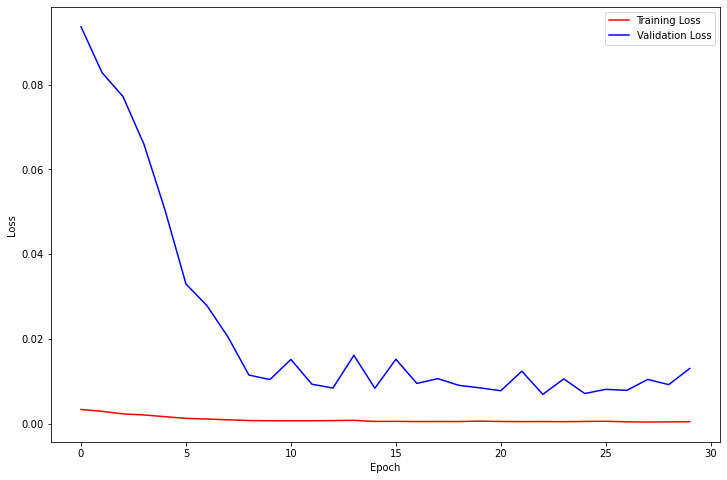

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [17]:
pred_test = model.predict(X_test)
pred_train = model.predict (X_train)

In [18]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()

,y_test,Predictions,Date
311,0.301097,0.151252,2022-04-21
312,0.299969,0.150540,2022-04-22
313,0.293635,0.151601,2022-04-23
314,0.292903,0.152593,2022-04-24
315,0.297096,0.151551,2022-04-25


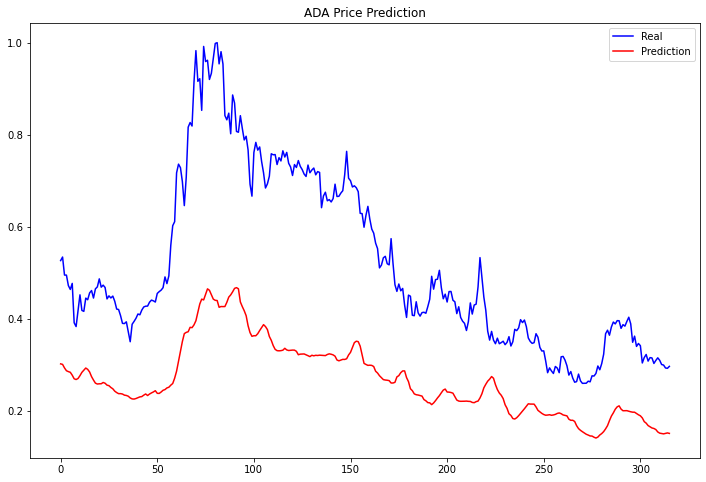

In [19]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred_test, color='red', label='Prediction')
plt.title('ADA Price Prediction')
plt.legend()
plt.show()

In [20]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.05436780349340661
Train data MSE:  0.0029558580566976765
Train data MAE:  0.025200418154204714
-------------------------------------------------------------------------------------
Test data RMSE:  0.27428484022546284
Test data MSE:  0.0752321735775077
Test data MAE:  0.24779514819433138


In [21]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.8330631200789307
Test data R2 score: -1.0929220029565339


# Model 2: XGBoost Regressor<a name="xgboost"></a>

In [22]:
data1 = ada.copy()
data1.reset_index(inplace = True)
data1.shape

(1614, 8)

In [23]:
close_stock = data1.copy()
print("Total data for prediction: ",data1.shape[0])

Total data for prediction:  1614


In [24]:
data1.set_index('Date', inplace = True)

In [25]:
data1.shape

(1614, 7)

In [26]:
training_size=int(len(data1)*0.80)
test_size=len(data1)-training_size
train_data,test_data=data1.iloc[:training_size,:],data1.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1291, 7)
test_data:  (323, 7)


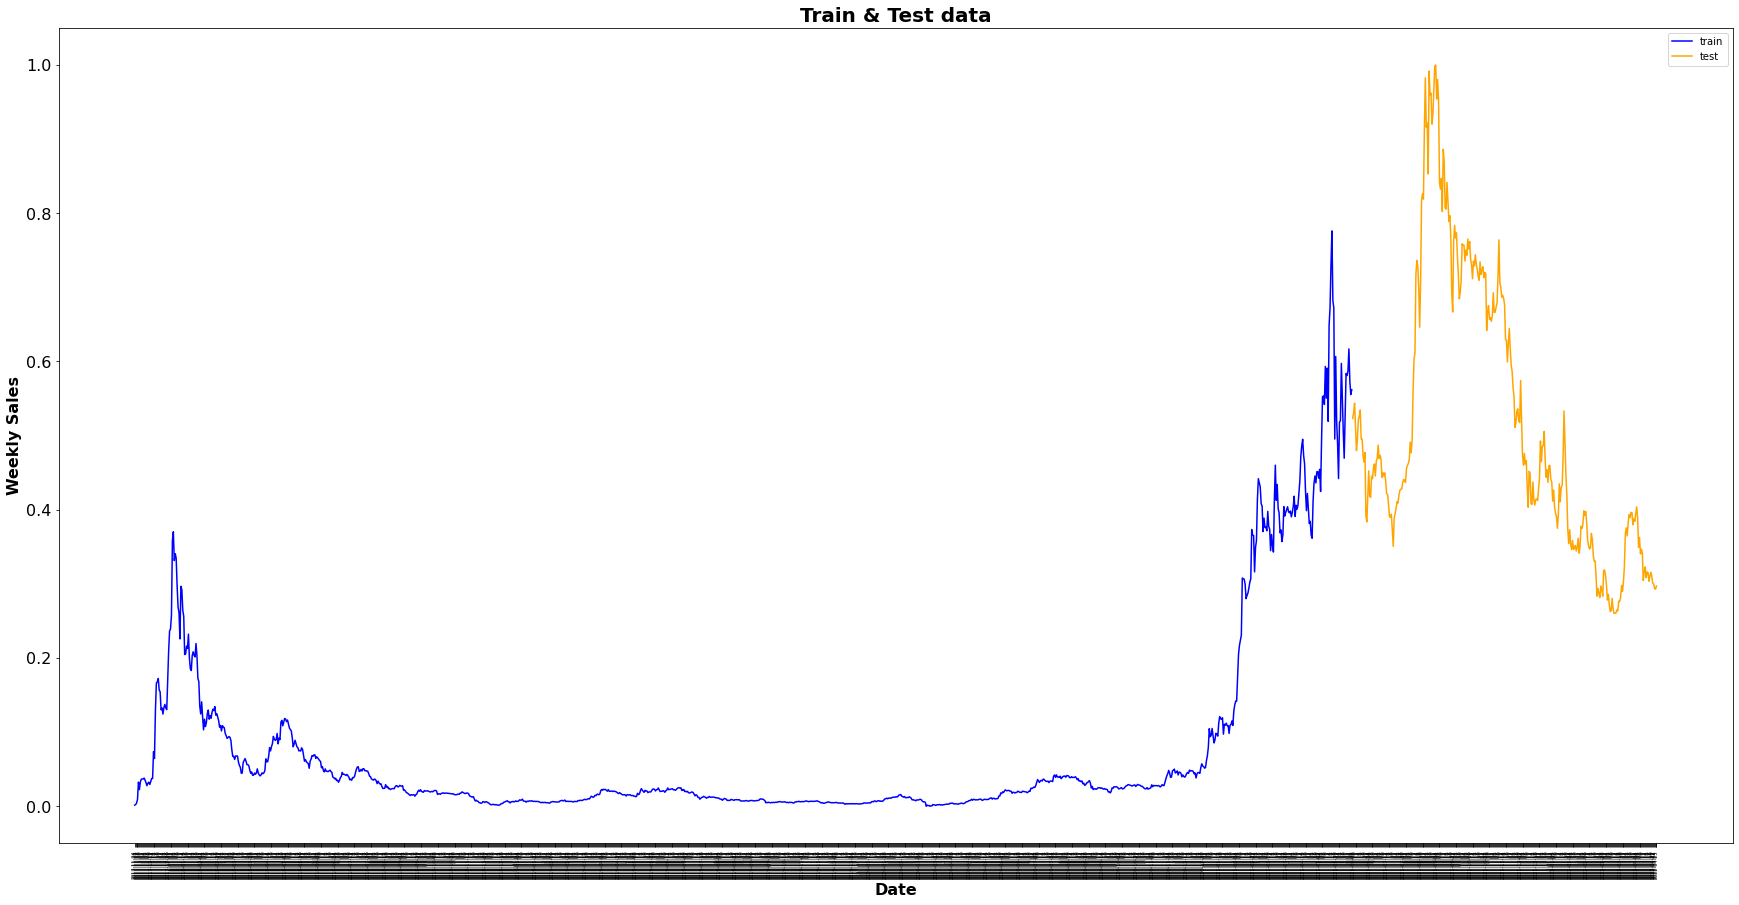

In [27]:
fig, ax = plt.subplots(figsize=(30, 15))
sns.lineplot(x = close_stock['Date'][:training_size], y = close_stock['close'][:training_size], color = 'blue')
sns.lineplot(x = close_stock['Date'][training_size:], y = close_stock['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', labelsize=5)
plt.xticks(rotation='vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [28]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), 0:]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [29]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1283, 7, 7)
y_train:  (1283,)
X_test:  (315, 7, 7)
y_test (315,)


In [30]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [31]:
model1 = XGBRegressor(n_estimators=1000, random_state = 1)
model1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, reg_lambda=1, ...)

In [32]:
predictions = model1.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)

predictions_train = model1.predict(X_train).reshape(-1,1)

In [33]:
results2 = np.concatenate((y_test, predictions),axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data1['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
310,0.310222,0.361086,2022-04-21
311,0.301097,0.363771,2022-04-22
312,0.299969,0.333453,2022-04-23
313,0.293635,0.303582,2022-04-24
314,0.292903,0.300041,2022-04-25


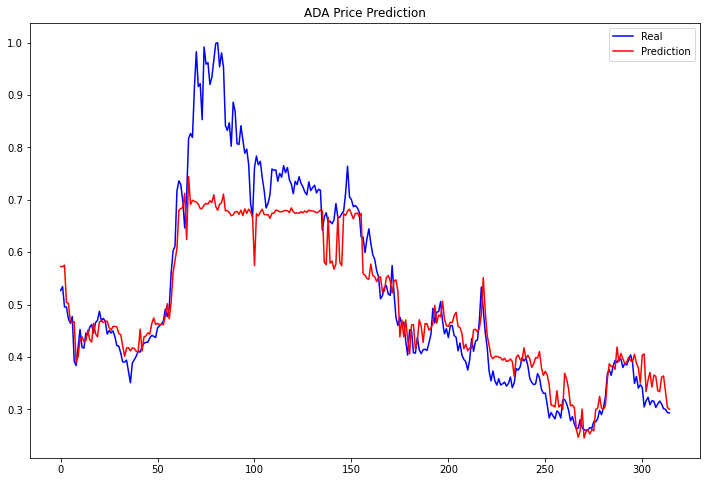

In [34]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(predictions, color='red', label='Prediction')
plt.title('ADA Price Prediction')
plt.legend()
plt.show()

In [35]:
print ('Test: ')
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score - Coefficient of Determination', r2_score(y_test, predictions))
print ("----------------------------------------------------------------")
print('Train:')
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score - Coefficient of Determination', r2_score(y_train, predictions_train))

Test: 
Mean Absolute Error - MAE : 0.05108241978127293
Root Mean squared Error - RMSE : 0.07859946904350586
R^2 Score - Coefficient of Determination 0.8279499085168661
----------------------------------------------------------------
Train:
Mean Absolute Error - MAE : 0.00044190125547240595
Root Mean squared Error - RMSE : 0.0006129885824286719
R^2 Score - Coefficient of Determination 0.9999773222560278


# ADA - since January 2021<a name="jan2021"></a>

# Model 1: LSTM <a name="lstm2"></a>

In [36]:
data2 = ada.copy()

In [37]:
data2.reset_index(inplace = True)
data2 = data2[data2['Date'] >= '2021-01-01']
data2.set_index('Date', inplace = True)
print("Total data for prediction: ",data2.shape[0])

Total data for prediction:  480


In [38]:
hist = []
target = []
length = 7

for i in range(len(data2)-length):
    t = data2['close']
    v = data2[['close','volume', 'spread', 'volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [39]:
print(len(hist[0]))
print(len(hist))
print(len(target))

7
473
473


In [40]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [41]:
target = target.reshape(-1,1)
target.shape

(473, 1)

In [42]:
training_size = int(len(data2)*0.8)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [43]:
X_train.shape

(384, 7, 6)

In [44]:
model2 = tf.keras.Sequential()

model2.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,6), dropout = 0.2))

model2.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model2.add(layers.LSTM(units=32, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model2.add(layers.Dense(units=1))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 20)             2160      
                                                                 
 lstm_4 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,297
Trainable params: 17,297
Non-trainable params: 0
_________________________________________________________________


In [45]:
model2.compile(optimizer='adam', loss='mean_squared_error')

In [46]:
history = model2.fit(X_train, y_train,  epochs=30, batch_size=32, validation_split=0.2, shuffle = False)

Epoch 1/30
10/10 [==============================] - 5s 94ms/step - loss: 0.2423 - val_loss: 0.1261
Epoch 2/30
10/10 [==============================] - 0s 16ms/step - loss: 0.1112 - val_loss: 0.0234
Epoch 3/30
10/10 [==============================] - 0s 13ms/step - loss: 0.0280 - val_loss: 0.0247
Epoch 4/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0825 - val_loss: 0.0066
Epoch 5/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0569 - val_loss: 0.0077
Epoch 6/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0412 - val_loss: 0.0061
Epoch 7/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0391 - val_loss: 0.0068
Epoch 8/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0415 - val_loss: 0.0060
Epoch 9/30
10/10 [==============================] - 0s 13ms/step - loss: 0.0383 - val_loss: 0.0052
Epoch 10/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0344 - val_loss: 0.0050
Epoch 11/

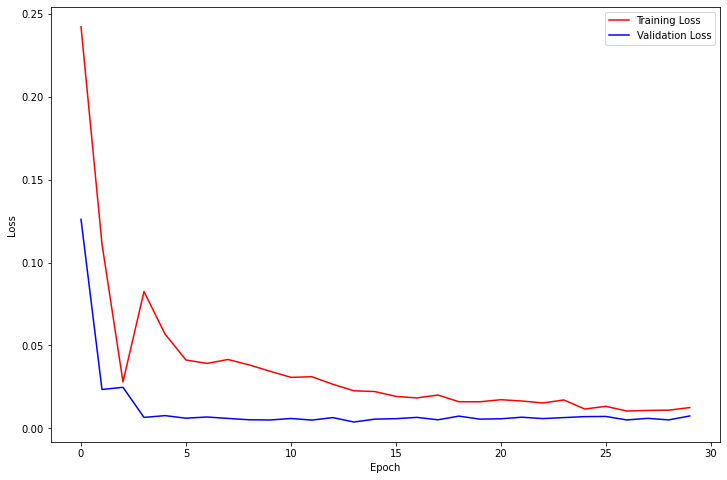

In [47]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [48]:
pred_test = model2.predict(X_test)
pred_train = model2.predict(X_train)

In [49]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data2['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()
results.head()

,y_test,Predictions,Date
0,0.346289,0.490684,2022-01-27
1,0.348692,0.471680,2022-01-28
2,0.351736,0.455085,2022-01-29
3,0.344231,0.451314,2022-01-30
4,0.349268,0.443517,2022-01-31


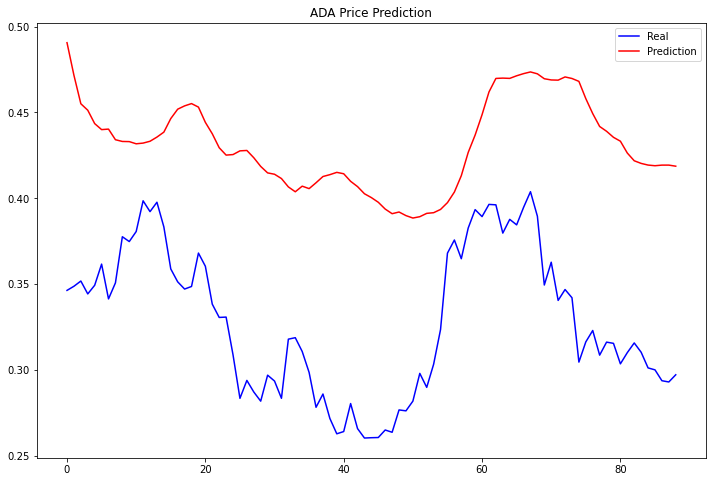

In [50]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred_test, color='red', label='Prediction')
plt.title('ADA Price Prediction')
plt.legend()
plt.show()

In [51]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.07618346290437884
Train data MSE:  0.005803920020102868
Train data MAE:  0.059860688385261374
-------------------------------------------------------------------------------------
Test data RMSE:  0.10760997400800412
Test data MSE:  0.011579906506003323
Test data MAE:  0.1027822902582798


In [52]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.850345349810476
Test data R2 score: -5.463112643966122


# Model 2: XGBoost Regressor <a name="xgboost2"></a>

In [53]:
data3 = ada.copy()
data3.reset_index(inplace = True)

In [54]:
data3.head(10)

,Date,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
0,2017-11-24,0.001502,0.000000,0.518040,0.001022,0.029306,0.999606,0.645889
1,2017-11-25,0.002203,0.000034,0.634866,0.002088,0.051031,1.000000,0.645889
2,2017-11-26,0.004202,0.001308,0.752464,0.009129,0.187687,0.993543,0.645889
3,2017-11-27,0.009045,0.003777,0.823601,0.019906,0.333804,0.988024,0.685035
4,2017-11-28,0.032532,0.012272,0.851392,0.083214,1.000000,0.978030,0.673386
5,2017-11-29,0.022334,0.010719,0.762251,0.064893,0.329965,0.895178,0.642704
6,2017-11-30,0.032579,0.006210,0.755405,0.032778,0.206944,0.984567,0.644827
7,2017-12-01,0.036474,0.003562,0.750013,0.017718,0.088619,1.000000,0.669793
8,2017-12-02,0.036814,0.002676,0.872784,0.009129,0.038037,0.988053,0.669793
9,2017-12-03,0.036629,0.002140,0.906398,0.013670,0.058657,0.986412,0.669793


In [55]:
data3 = data3[(data3['Date'] >= '2021-01-01')]
data3.set_index('Date', inplace = True)
print("Total data for prediction: ",data3.shape[0])

Total data for prediction:  480


In [56]:
data3.shape

(480, 7)

In [57]:
training_size=int(len(data3)*0.80)
test_size=len(data3)-training_size
train_data,test_data=data3.iloc[:training_size,:],data3.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (384, 7)
test_data:  (96, 7)


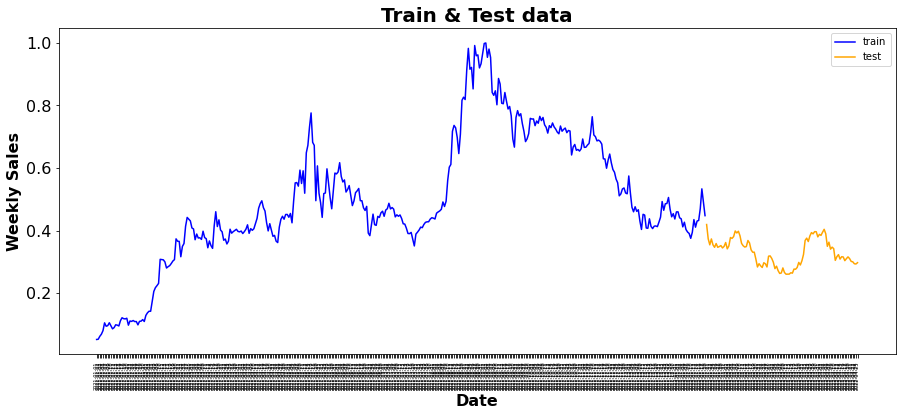

In [58]:
data3.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = data3['Date'][:training_size], y = data3['close'][:training_size], color = 'blue')
sns.lineplot(x = data3['Date'][training_size:], y = data3['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.xticks(rotation = 'vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [59]:
data3.set_index('Date', inplace = True)

In [60]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        a = dataset.iloc[i:(i+time_step), :]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [61]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (377, 7, 7)
y_train:  (377,)
X_test:  (89, 7, 7)
y_test (89,)


In [62]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [63]:
model3 = XGBRegressor(n_estimators=1000, random_state = 1, max_depth=2, eta = 0.01, learning_rate = 0.05)
model3.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.01,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, ...)

In [64]:
predictions = model3.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)

predictions_train = model3.predict(X_train).reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [65]:
results2 = np.concatenate((y_test, predictions), axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data3['close'].tail(len(y_test))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
84,0.301097,0.374857,2022-04-21
85,0.299969,0.343088,2022-04-22
86,0.293635,0.332447,2022-04-23
87,0.292903,0.322872,2022-04-24
88,0.297096,0.315270,2022-04-25


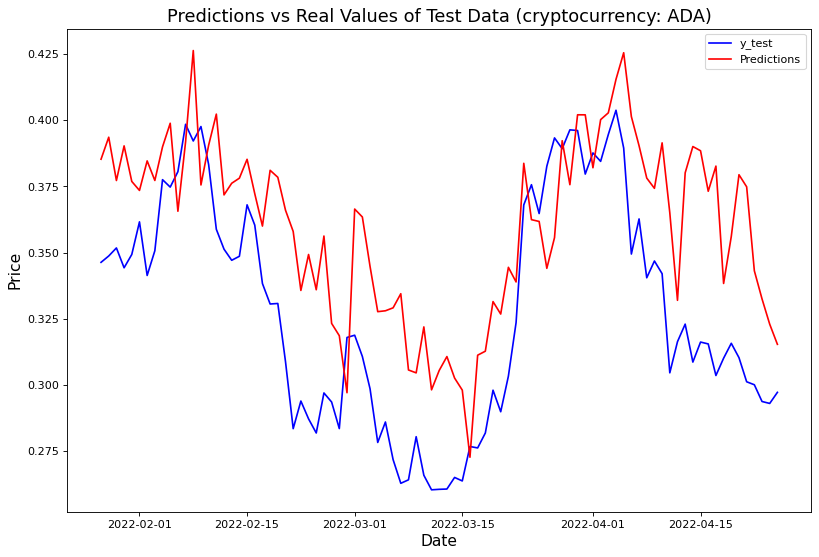

In [66]:
plt.figure(figsize = (12,8), dpi = 80 )
plt.plot(results2['Date'], results2['y_test'], 'b', label = 'y_test')
plt.plot(results2['Date'], results2['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: ADA)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [67]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  4.1182550277705855e-05
Mean Absolute Error - MAE : 0.004893010343870912
Root Mean squared Error - RMSE : 0.0064173631872994265
R^2 Score 0.9989480347459933
--------------------------------------------------------------
Test data MSE:  0.0016460092036875364
Mean Absolute Error - MAE : 0.03577485520892204
Root Mean squared Error - RMSE : 0.040571038977176024
R^2 Score 0.0813101218975878


# ADA - since January 2022  <a name="jan2022"></a>

# Model 1: LSTM <a name="lstm3"></a>

In [68]:
data4 = ada.copy()
data4.reset_index(inplace = True)
data4 = data4[data4['Date'] >= '2022-01-01']
data4.set_index('Date', inplace = True)
print("Total data for prediction: ",data4.shape[0])

Total data for prediction:  115


In [69]:
hist = []
target = []
length = 7

for i in range(len(data4)-length):
    t = data4['close']
    v = data4[['close','volume', 'spread', 'volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [70]:
print(len(hist[0]))
print(len(hist))
print(len(target))

7
108
108


In [71]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [72]:
target = target.reshape(-1,1)
target.shape

(108, 1)

In [73]:
training_size = int(len(data4)*0.8)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [74]:
X_train.shape

(92, 7, 6)

In [75]:
model4 = tf.keras.Sequential()

model4.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,6), dropout = 0.2))

model4.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model4.add(layers.LSTM(units=32, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model4.add(layers.Dense(units=1))

model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 7, 20)             2160      
                                                                 
 lstm_7 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,297
Trainable params: 17,297
Non-trainable params: 0
_________________________________________________________________


In [76]:
model4.compile(optimizer='adam', loss='mean_squared_error')

In [77]:
history = model4.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, shuffle = False)

Epoch 1/30
3/3 [==============================] - 5s 327ms/step - loss: 0.1152 - val_loss: 0.1133
Epoch 2/30
3/3 [==============================] - 0s 27ms/step - loss: 0.0922 - val_loss: 0.0921
Epoch 3/30
3/3 [==============================] - 0s 26ms/step - loss: 0.0735 - val_loss: 0.0718
Epoch 4/30
3/3 [==============================] - 0s 28ms/step - loss: 0.0545 - val_loss: 0.0511
Epoch 5/30
3/3 [==============================] - 0s 28ms/step - loss: 0.0367 - val_loss: 0.0307
Epoch 6/30
3/3 [==============================] - 0s 23ms/step - loss: 0.0199 - val_loss: 0.0129
Epoch 7/30
3/3 [==============================] - 0s 25ms/step - loss: 0.0084 - val_loss: 0.0022
Epoch 8/30
3/3 [==============================] - 0s 28ms/step - loss: 0.0071 - val_loss: 4.7973e-04
Epoch 9/30
3/3 [==============================] - 0s 31ms/step - loss: 0.0086 - val_loss: 4.7278e-04
Epoch 10/30
3/3 [==============================] - 0s 24ms/step - loss: 0.0076 - val_loss: 0.0014
Epoch 11/30
3/3 [===

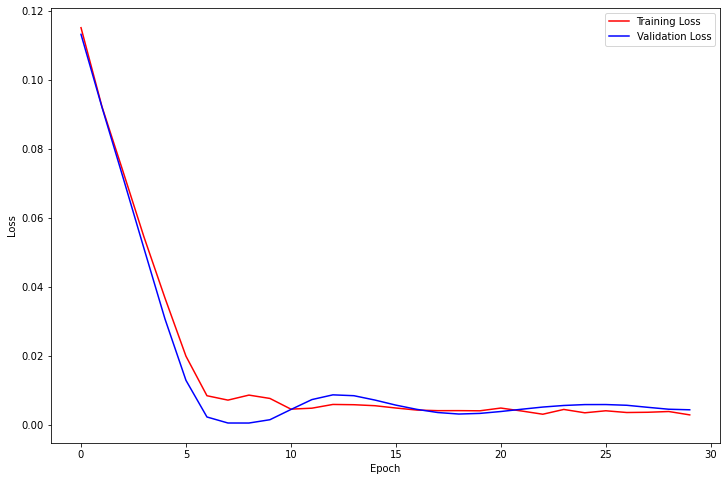

In [78]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [79]:
pred_test = model4.predict(X_test)
pred_train = model4.predict (X_train)

In [80]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data4['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()

,y_test,Predictions,Date
11,0.301097,0.292072,2022-04-21
12,0.299969,0.291666,2022-04-22
13,0.293635,0.290891,2022-04-23
14,0.292903,0.290375,2022-04-24
15,0.297096,0.291155,2022-04-25


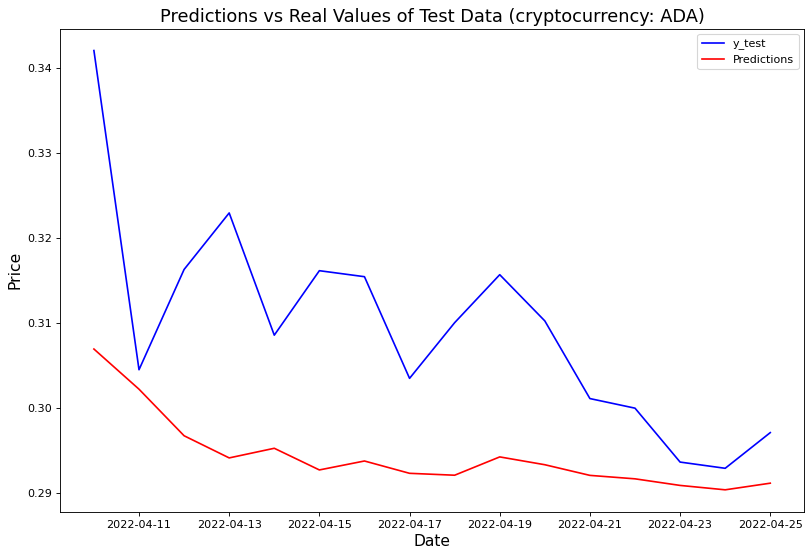

In [81]:
plt.figure(figsize = (12,8), dpi = 80)
plt.plot(results['Date'], results['y_test'], 'b', label = 'y_test')
plt.plot(results['Date'], results['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: ADA)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [82]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.05483582360335767
Train data MSE:  0.0030069675502585576
Train data MAE:  0.043853270928265006
-------------------------------------------------------------------------------------
Test data RMSE:  0.017729463749487664
Test data MSE:  0.0003143338848443972
Test data MAE:  0.014999189289730389


In [83]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.030482873188521054
Test data R2 score: -1.1832877224234184


# Model 2: XGBoost Regressor   <a name="xgboost3"></a>

In [84]:
data5= ada.copy()
data5.reset_index(inplace = True)
data5 = data5[data5['Date'] >= '2022-01-01']
data5.set_index('Date', inplace = True)
print("Total data for prediction: ",data5.shape[0])

Total data for prediction:  115


In [85]:
training_size=int(len(data5)*0.80)
test_size=len(data5)-training_size
train_data,test_data=data5.iloc[:training_size,:],data5.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (92, 7)
test_data:  (23, 7)


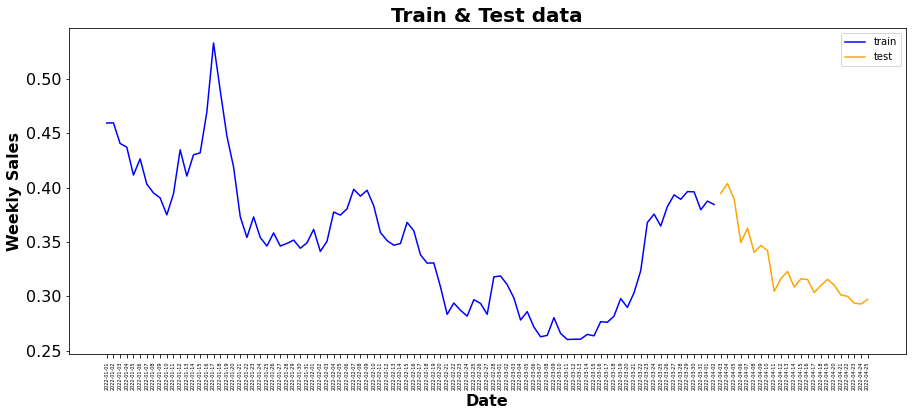

In [86]:
data5.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = data5['Date'][:training_size], y = data5['close'][:training_size], color = 'blue')
sns.lineplot(x = data5['Date'][training_size:], y = data5['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.xticks(rotation = 'vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [87]:
data5.set_index('Date', inplace = True)

In [88]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), :]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [89]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (84, 7, 7)
y_train:  (84,)
X_test:  (15, 7, 7)
y_test (15,)


In [90]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [91]:
model5 = XGBRegressor(n_estimators=1000, random_state = 1, eta = 0.2)
model5.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, ...)

In [92]:
predictions = model5.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)


predictions_train = model5.predict(X_train).reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [93]:
results2 = np.concatenate((y_test, predictions), axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data5['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
10,0.310222,0.315433,2022-04-21
11,0.301097,0.317212,2022-04-22
12,0.299969,0.306884,2022-04-23
13,0.293635,0.288256,2022-04-24
14,0.292903,0.293839,2022-04-25


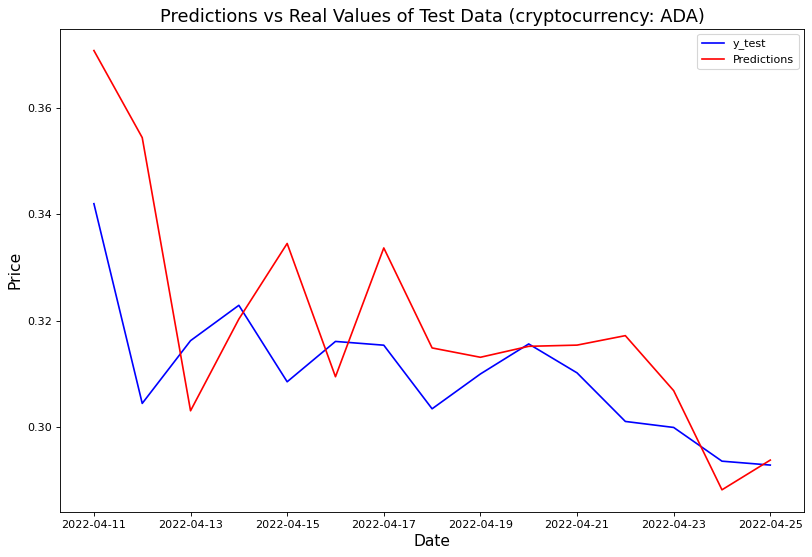

In [94]:
plt.figure(figsize = (12,8), dpi = 80 )
plt.plot(results2['Date'], results2['y_test'], 'b', label = 'y_test')
plt.plot(results2['Date'], results2['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: ADA)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [95]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  1.7384579154953016e-07
Mean Absolute Error - MAE : 0.0003150583232292783
Root Mean squared Error - RMSE : 0.000416948188087597
R^2 Score 0.9999471841785492
--------------------------------------------------------------
Test data MSE:  0.00033713762191426715
Mean Absolute Error - MAE : 0.012992152385746062
Root Mean squared Error - RMSE : 0.018361307739762633
R^2 Score -1.3597433098263187


# Predictions for the next two days using the best model <a name="predictions"></a>

In [96]:
#Importing the dataset with the updated data
#Use just the 7 past rows, because our model is predicting based on this sliding window
predictions = pd.read_csv('test_ADA.csv', index_col = 'Date')

In [97]:
predictions.tail(7)

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
Date,,,,,,,
2022-05-02,0.257302,0.041796,0.134111,0.029023,0.015833,0.973809,0.015836
2022-05-03,0.253775,0.033661,0.156091,0.035928,0.021465,0.949697,0.002421
2022-05-04,0.296501,0.078934,0.323298,0.127480,0.094051,0.998682,0.012130
2022-05-05,0.260570,0.093885,0.358716,0.125426,0.078474,0.792953,0.058967
2022-05-06,0.257923,0.068287,0.400958,0.031978,0.018082,0.972587,0.017718
2022-05-07,0.250629,0.041599,0.203497,0.033865,0.019794,0.957413,0.017718
2022-05-08,0.244678,0.056798,0.134467,0.031369,0.018563,0.964549,0.017718


In [98]:
predictions1 = predictions.tail(7)
predictions1 = np.array(predictions1)

In [99]:
x_input=predictions1[len(predictions1)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

output9=[]
n_steps=7
i=0
pred_days = 1


In [100]:
while(i<pred_days):
    
    if(len(temp_input)>time_step):        
        x_input=np.array(temp_input[i:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = model3.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[i:]
       
        output9.extend(yhat.tolist())
        i=i+1
        
print("Output of predicted next days: ", len(output9))

0 day input [0.25730179 0.04179572 0.13411149 0.02902301 0.01583305 0.97380915
 0.01583568 0.25377494 0.03366074 0.15609101 0.03592785 0.02146507
 0.94969672 0.00242126 0.29650087 0.07893411 0.3232985  0.12748035
 0.0940513  0.9986822  0.01213009 0.26057016 0.0938849  0.3587157
 0.12542625 0.07847411 0.7929526  0.05896673 0.25792333 0.06828745
 0.40095837 0.03197764 0.01808184 0.97258652 0.01771789 0.25062884
 0.04159891 0.20349718 0.03386469 0.01979356 0.9574134  0.01771789
 0.24467848 0.05679849 0.13446738 0.03136945 0.01856257 0.96454896
 0.01771789]
0 day output [0.33468667]
Output of predicted next days:  1


In [101]:
output9  #predicted closing price for May 9th, 2022 (Monday)

[0.33468666672706604]

In [102]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[1 2 3 4 5 6 7]
[8]


In [103]:
# Inserting the prediction for the row May 9th, 2022 --> using new predicted value + data from May 8th 2022 for the other variables 

In [104]:
a = predictions.tail(1).copy()
a.reset_index(inplace = True)
a

,Date,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
0,2022-05-08,0.244678,0.056798,0.134467,0.031369,0.018563,0.964549,0.017718


In [105]:
a.at[0,'Date']='2022-05-09'
a.at[0,'close']= output9[0]
a.set_index('Date', inplace = True)
a

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
Date,,,,,,,
2022-05-09,0.334687,0.056798,0.134467,0.031369,0.018563,0.964549,0.017718


In [106]:
final_predictions = pd.concat([predictions, a], axis=0, join='outer')

In [107]:
#Get the predicted denormalized closing price using MinMaxScaler formula
intermediate_result = ((2.96639-0.023954)*output9[0])+0.023954

print ("The predicted closing price for ADA on May 9th, 2022 is ", intermediate_result, "USD")

The predicted closing price for ADA on May 9th, 2022 is  1.0087480968977214 USD


# Final Predictions<a name="finalpredictions"></a>

In [108]:
final_predictions.tail(7)

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
Date,,,,,,,
2022-05-03,0.253775,0.033661,0.156091,0.035928,0.021465,0.949697,0.002421
2022-05-04,0.296501,0.078934,0.323298,0.127480,0.094051,0.998682,0.012130
2022-05-05,0.260570,0.093885,0.358716,0.125426,0.078474,0.792953,0.058967
2022-05-06,0.257923,0.068287,0.400958,0.031978,0.018082,0.972587,0.017718
2022-05-07,0.250629,0.041599,0.203497,0.033865,0.019794,0.957413,0.017718
2022-05-08,0.244678,0.056798,0.134467,0.031369,0.018563,0.964549,0.017718
2022-05-09,0.334687,0.056798,0.134467,0.031369,0.018563,0.964549,0.017718


In [109]:
final_predictions1 = final_predictions.tail(7)
final_predictions1 = np.array(final_predictions1)

In [110]:
x_input=(final_predictions1[len(final_predictions1)-(time_step*time_step):]).reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

output10=[]
n_steps=7
i=0
pred_days = 1

In [111]:
while(i<pred_days):
    
    if(len(temp_input)>time_step):        
        x_input=np.array(temp_input[i:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = model3.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[i:]
       
        output10.extend(yhat.tolist())
        i=i+1
        
print("Output of predicted next days: ", len(output10))

0 day input [0.25377494 0.03366074 0.15609101 0.03592785 0.02146507 0.94969672
 0.00242126 0.29650087 0.07893411 0.3232985  0.12748035 0.0940513
 0.9986822  0.01213009 0.26057016 0.0938849  0.3587157  0.12542625
 0.07847411 0.7929526  0.05896673 0.25792333 0.06828745 0.40095837
 0.03197764 0.01808184 0.97258652 0.01771789 0.25062884 0.04159891
 0.20349718 0.03386469 0.01979356 0.9574134  0.01771789 0.24467848
 0.05679849 0.13446738 0.03136945 0.01856257 0.96454896 0.01771789
 0.33468667 0.05679849 0.13446738 0.03136945 0.01856257 0.96454896
 0.01771789]
0 day output [0.31925473]
Output of predicted next days:  1


In [112]:
print ("The predicted normalized closing price for ADA on May 10th, 2022 is ", output10[0])

The predicted normalized closing price for ADA on May 10th, 2022 is  0.31925472617149353


In [113]:
#Get the predicted denormalized closing price using MinMaxScaler formula
final_result = ((2.96639-0.023954)*output10[0])+0.023954

print ("The predicted closing price for ADA on May 10th, 2022 is ", final_result, "USD")

The predicted closing price for ADA on May 10th, 2022 is  0.9633405994571449 USD
